# Building an LSTM neural network

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function

# import local library
import tools
import nnlstm

# import library to build the neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam

In [3]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# for reproducibility
%watermark -a 'Paul Willot' -mvp numpy,scipy,keras

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Paul Willot 

CPython 2.7.10
IPython 4.0.0

numpy 1.8.0rc1
scipy 0.13.0b1
keras 0.1.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.39)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


---
Let's gather the datas from the previous notebook

In [5]:
X_train, y_train, X_test, y_test, feature_names,max_features, classes_names, vectorizer = tools.load_pickle("data/unpadded_4_BacObjMetCon.pickle")

Loading 'data/unpadded_4_BacObjMetCon.pickle'...
Done. [0.23s]


and pad each vector to a regular size (necessary for the sequence processing)

In [6]:
X_train, X_test, y_train, y_test = nnlstm.pad_sequence(X_train, X_test, y_train, y_test, maxlen=100)

Pading sequences...
X_train shape: (1427, 100)
X_test shape: (357, 100)
Done. [0.02s]


Or directly get a **bigger training and testing set**:

In [7]:
X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("data/training_4_BacObjMetCon.pickle")

Loading 'data/training_4_BacObjMetCon.pickle'...
'data/training_4_BacObjMetCon.pickle' not found, trying 'data/training_4_BacObjMetCon.pickle.pickle'


IOError: [Errno 2] No such file or directory: 'data/training_4_BacObjMetCon.pickle.pickle'

Our data look like this:

In [8]:
X_train[0][:100]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   93,  117,   29, 3331,
        872, 2323, 2473, 4119, 2455, 2452, 1348, 1770, 2290, 2691,   97,
       1452], dtype=int32)

In [9]:
# one-hot vector for the 4 different labels
y_train[0]

array([ 0.,  1.,  0.,  0.])

# Choosing the architecture

We use the [Keras](https://github.com/fchollet/keras) library, build on [Theano](https://github.com/Theano/Theano).

Here I choose a very simple architecture because of my low performance system (with no graphic card), but of course feel free to try any. Especially, stacking layers of LSTM could improve performance, according to [this paper](http://arxiv.org/abs/1506.02078) from Karpathy (which I used a lot as reference)

In [10]:
%%time
# take approximately 50s to build
dim_out = len(classes_names)

net = Sequential()
net.add(Embedding(max_features, 16))
net.add(LSTM(16, 16))
net.add(Dense(16, dim_out))
net.add(Dropout(0.5))
net.add(Activation('softmax'))
net.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

CPU times: user 44.8 s, sys: 725 ms, total: 45.5 s
Wall time: 54.7 s


/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


Training on a small subset

In [12]:
batch_size   = 100
length_train = 15000  # length of the reduced training set (can put to -1 for all)
length_test  = 5000   # length of the reduced testing set  (can put to -1 for all)
nb_epoch     = 10
patience     = 2      # when to apply early stopping, if necessary
history = nnlstm.train_network(net,
                        X_train[:length_train],
                        y_train[:length_train],
                        X_test[:length_test],
                        y_test[:length_test],
                        nb_epoch,
                        batch_size=batch_size,
                        path_save="weights",
                        patience=patience) 

Training...
Train on 1427 samples, validate on 357 samples
Epoch 0
1427/1427 [==============================] - 1s - loss: 1.2596 - acc: 0.4345 - val_loss: 1.2842 - val_acc: 0.3978
Saving at first epoch
Epoch 1
1427/1427 [==============================] - 1s - loss: 1.1916 - acc: 0.4961 - val_loss: 1.2313 - val_acc: 0.5266
Model improved, saving weight
Epoch 2
1427/1427 [==============================] - 1s - loss: 1.1942 - acc: 0.4569 - val_loss: 1.1939 - val_acc: 0.5126
Epoch 3
1427/1427 [==============================] - 1s - loss: 1.1063 - acc: 0.5067 - val_loss: 1.1429 - val_acc: 0.6162
Model improved, saving weight
Epoch 4
1427/1427 [==============================] - 1s - loss: 1.0956 - acc: 0.5165 - val_loss: 1.1283 - val_acc: 0.5994
Epoch 5
1427/1427 [==============================] - 1s - loss: 1.0412 - acc: 0.5431 - val_loss: 1.1053 - val_acc: 0.6835
Model improved, saving weight
Epoch 6
1427/1427 [==============================] - 1s - loss: 1.0101 - acc: 0.5298 - val_loss: 

The **weights are saved at each epoch**, and you can load '`best`' for the epoch with the higher (accuracy * (loss/10))

In [13]:
net.load_weights("weights/best.hdf5")

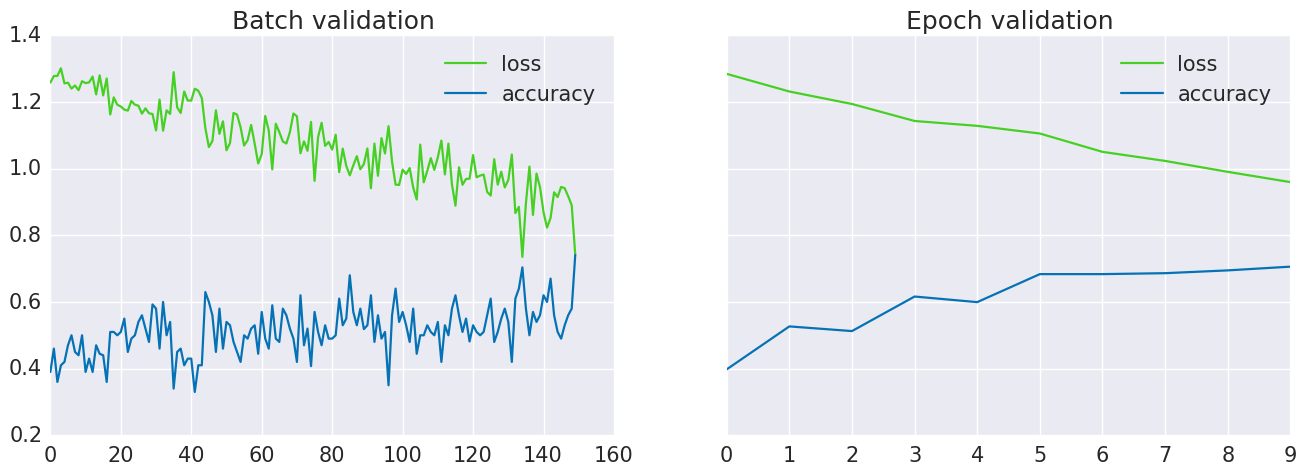

In [14]:
nnlstm.show_history(history)

# Evaluate the network

No decision: 0 / 356  [0.00%]0 0
Accuracy: 0.830993
             precision    recall  f1-score   support

 BACKGROUND       0.68      0.81      0.73        67
     METHOD       0.86      0.54      0.66       131
     RESULT       0.35      0.55      0.43        55
 CONCLUSION       0.90      0.94      0.92       103

avg / total       0.76      0.71      0.71       356

Confusion matrix:
[[54  6  6  1]
 [11 71 43  6]
 [15  6 30  4]
 [ 0  0  6 97]]


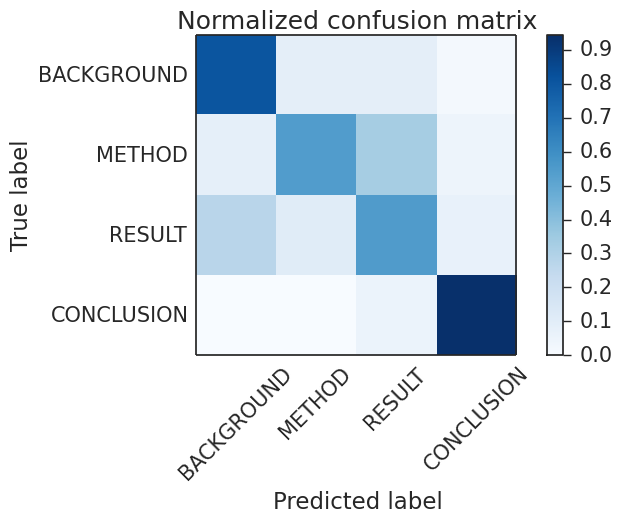

In [15]:
nnlstm.evaluate_network(net, X_test[:length_test], y_test[:length_test], classes_names, length=-1)

It is interesting to note the confusion of the network between `Background` and `Objective`, as the difference between these two labels is indeed usually quite thin.

---
## What's next?
There is a lot of possible improvments, from simply trying new features to implement transfer training...  

For an other nice and more complete example of LSTM neural network usage, you can look at [Karpathy's blogpost](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Hopefully this notebook was helpful for you in some way. If there is some issues with this repo feel free to submit an issue or give me a comment, I'm always glad to have some feedback!  



Paul Willot
